# Load Libraries

In [245]:
# data exploration
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# data preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

# modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# tuning hyperparameter
from sklearn.model_selection import GridSearchCV
import optuna

# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# utils
import re
import string
import math
import pickle


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

dictionary = np.array([word.replace('\n', '') for word in open("./dataset/kata-dasar.txt", 'r').readlines()])

# additional stopword
stop = ['tp','kl','yg','klo','tpi','yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena',  'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 'sebetulnya',  'setiap', 'setidaknya', 'sesuatu', 'pasti', 'saja', 'toh', 'ya', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun']

stop_add = [x for x in stop if x not in stop_words]
for word in stop_add:
  stop_words.add(word)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

[nltk_data] Downloading package punkt to /Users/affan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/affan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [3]:
# mapping kabupaten kota data
data_prov = pd.read_csv('./dataset/mapping_kab_kot_prov.csv')

# zonasi tweet data
zonasi = pd.read_csv('./dataset/zonasi-merger.csv')
zonasi.head()

,date,lokasi,status,text,time,tweet_id,username
0,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,1:10,1090673509301252096,@yusuf_rizqi
1,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,0:53,1090669319548096512,@yusuf_rizqi
2,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani
3,2019-01-30,ĂœT: 3.58763298.675553,200,usul pak benahi dulu sekolah fasilitas dan g...,21:11,1090613490824359936,@dewy_tito
4,2019-01-30,NaN,200,"RT pdkjateng ""RT Kemdikbud_RI: #SahabatDikbud ...",19:23,1090586251722440704,@andri000me_20


In [4]:
zonasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21347 entries, 0 to 21346
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      21347 non-null  object
 1   lokasi    14524 non-null  object
 2   status    21347 non-null  int64 
 3   text      21347 non-null  object
 4   time      21347 non-null  object
 5   tweet_id  21347 non-null  object
 6   username  21347 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


ok, we have missing values on lokasi. we will fill it with 'unknown' since we need to retain the text data for modelling purpose.

### Handle Missing Values

In [5]:
zonasi.fillna('unknown', axis=1, inplace=True)
zonasi.head()

,date,lokasi,status,text,time,tweet_id,username
0,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,1:10,1090673509301252096,@yusuf_rizqi
1,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,0:53,1090669319548096512,@yusuf_rizqi
2,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani
3,2019-01-30,ĂœT: 3.58763298.675553,200,usul pak benahi dulu sekolah fasilitas dan g...,21:11,1090613490824359936,@dewy_tito
4,2019-01-30,unknown,200,"RT pdkjateng ""RT Kemdikbud_RI: #SahabatDikbud ...",19:23,1090586251722440704,@andri000me_20


now we did fill the missing value. but we still can spot strange ```lokasi``` value. we need to transform it later.
<br><br>
for now, let's remove duplicate data first. remember, since our task will be sentiment analysis then we will remove duplicate data based on ```text``` column

### Remove Duplicates

In [6]:
len_before_remove = len(zonasi)
print('length before remove duplicates: {}'.format(len_before_remove))

zonasi.drop_duplicates(subset='text', keep='last', inplace=True)

len_after_remove = len(zonasi)
print('length after remove duplicates: {}'.format(len_after_remove))

print('we have been successfully remove duplicate values and reduced the dataset {:.2f}%'\
    .format((len_before_remove - len_after_remove)/len_before_remove * 100))

length before remove duplicates: 21347
length after remove duplicates: 20989
we have been successfully remove duplicate values and reduced the dataset 1.68%


### Transform Strange Value in ```lokasi``` Column

In [35]:
kota = data_prov.kabupaten_kota.to_list()
kota = '|'.join(map(str.lower, kota))
filter_logic = zonasi.lokasi.str.lower().str.contains(kota)

# separate known and unknown kota based on mapping file
zonasi_kota = zonasi[filter_logic]
zonasi_unk_kota = zonasi[~filter_logic]

# replace unmatch kota with `unknown`
zonasi_unk_kota_rep = zonasi_unk_kota.copy()
zonasi_unk_kota_rep.loc[:, 'lokasi'] = 'unknown'

,date,lokasi,status,text,time,tweet_id,username
1,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,0:53,1090669319548096512,@yusuf_rizqi
2,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani
3,2019-01-30,unknown,200,usul pak benahi dulu sekolah fasilitas dan g...,21:11,1090613490824359936,@dewy_tito
4,2019-01-30,unknown,200,"RT pdkjateng ""RT Kemdikbud_RI: #SahabatDikbud ...",19:23,1090586251722440704,@andri000me_20
5,2019-01-30,unknown,200,saya warga dgn KTP dan KK semarang tapi krn pe...,19:05,1090581732208734208,@xcenthil


### Mapping Provinsi

In [60]:
# since the kota is unknown, then set provinsi to unknown too
zonasi_unk_kota_rep.loc[:, ('provinsi')] = 'unknown'

# now mapping provinsi for known kota
kotprov = list(zip(data_prov.kabupaten_kota.to_list(), data_prov.provinsi.to_list()))
lokasi = zonasi_kota.lokasi.to_list()

new_prov = []

for x, i in enumerate(lokasi):    
    for item in kotprov:
        if item[0].lower() in i.lower():
            new_prov.append(item[1])
            break
            


zonasi_kota_prov = zonasi_kota.copy()
zonasi_kota_prov.loc[:, ('provinsi')] = new_prov

# # merge both known and unknown kota again
zonasi = pd.concat([zonasi_kota_prov, zonasi_unk_kota_rep], axis=0).sort_index()
zonasi.head()

,date,lokasi,status,text,time,tweet_id,username,provinsi
1,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,0:53,1090669319548096512,@yusuf_rizqi,JAWA BARAT
2,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani,JAWA BARAT
3,2019-01-30,unknown,200,usul pak benahi dulu sekolah fasilitas dan g...,21:11,1090613490824359936,@dewy_tito,unknown
4,2019-01-30,unknown,200,"RT pdkjateng ""RT Kemdikbud_RI: #SahabatDikbud ...",19:23,1090586251722440704,@andri000me_20,unknown
5,2019-01-30,unknown,200,saya warga dgn KTP dan KK semarang tapi krn pe...,19:05,1090581732208734208,@xcenthil,unknown


In [61]:
zonasi.to_csv('./dataset/zonasi-transformed.csv', index=False)
print('transform data done.')

transform data done.


# Exploratory Data Analysis

In [64]:
zonasi = pd.read_csv('./dataset/zonasi-transformed.csv')
zonasi.head()

,date,lokasi,status,text,time,tweet_id,username,provinsi
0,2019-01-31,Kota Bandung Jawa Barat,200,Kenapa tidak dilakukan pemerataan kualitas dul...,0:53,1090669319548096512,@yusuf_rizqi,JAWA BARAT
1,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani,JAWA BARAT
2,2019-01-30,unknown,200,usul pak benahi dulu sekolah fasilitas dan g...,21:11,1090613490824359936,@dewy_tito,unknown
3,2019-01-30,unknown,200,"RT pdkjateng ""RT Kemdikbud_RI: #SahabatDikbud ...",19:23,1090586251722440704,@andri000me_20,unknown
4,2019-01-30,unknown,200,saya warga dgn KTP dan KK semarang tapi krn pe...,19:05,1090581732208734208,@xcenthil,unknown


In [70]:
print(zonasi.provinsi.sort_values().value_counts())

unknown                      15556
JAWA TIMUR                    1518
JAWA BARAT                    1288
JAWA TENGAH                    884
DI YOGYAKARTA                  557
DKI JAKARTA                    239
BANTEN                         230
SUMATERA UTARA                  83
SULAWESI SELATAN                82
BALI                            70
RIAU                            62
KEPULAUAN RIAU                  59
LAMPUNG                         49
KALIMANTAN TIMUR                41
KALIMANTAN BARAT                36
SUMATERA BARAT                  36
SUMATERA SELATAN                28
KALIMANTAN SELATAN              26
BENGKULU                        21
JAMBI                           20
ACEH                            20
SULAWESI UTARA                  19
KEPULAUAN BANGKA BELITUNG       14
NUSA TENGGARA BARAT             13
SULAWESI TENGAH                  8
NUSA TENGGARA TIMUR              6
KALIMANTAN UTARA                 6
SULAWESI TENGGARA                4
KALIMANTAN TENGAH   

Unfortunately there are more than 15k data that can't identified their exact province due to unclear address name on user profiles. This is because twitter allowed their user to write anything about their location. They didn't restrict their user to add location based on city or province only.
<br><br>
Another insight that we have here is sentiments about *zonasi sekolah* looks like centered in Java island. Followed by some big island like Sumatera, Sulawesi, and Kalimantan. Also some of famous island like Bali, Kep. Riau, and Nusa Tenggara Barat. I'm assume this is because we can found so many favorite school in those island, but not as many as that on the rest island. This indicates that Indonesia's development and education has not organized equally yet.

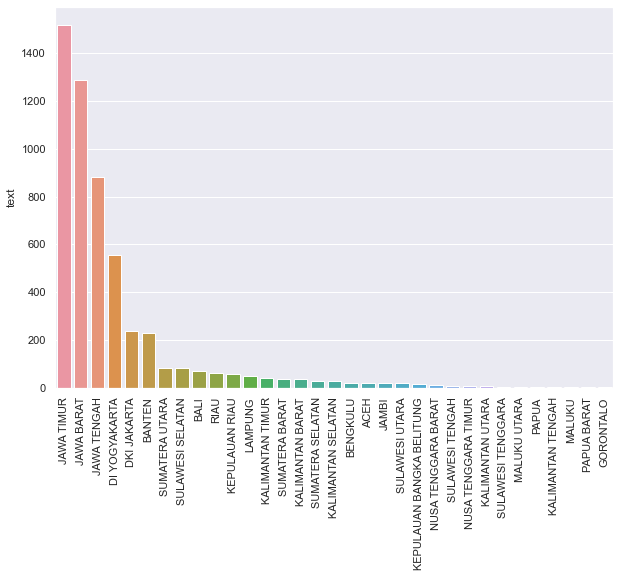

In [117]:
zonasi_grouped = zonasi[zonasi.provinsi != 'unknown'].groupby('provinsi').count()\
    .sort_values(by='text', ascending=False).reset_index()

plt.figure(figsize=(10,7))
sns.barplot(data=zonasi_grouped, x=zonasi_grouped.provinsi.to_list(), y='text')
plt.xticks(rotation=90)
plt.show()

In order to give a clearer view on the visualization, we remove data with unknown province. And again, we can see that most tweets comes from people that live in Java Island.

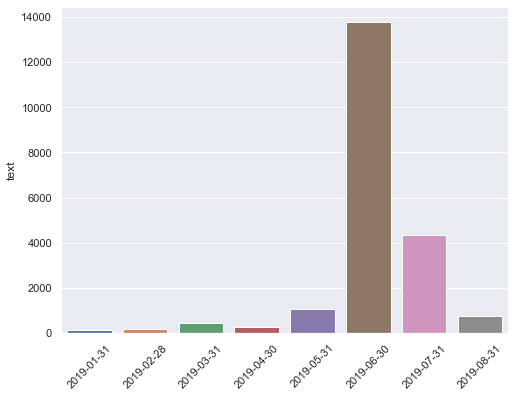

In [104]:
zonasi.date = pd.to_datetime(zonasi.date)
zonasi_sorted = zonasi.sort_values(by='date')

zonasi_sorted = zonasi_sorted.groupby(pd.Grouper(key='date', axis=0, freq='M')).count().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(data=zonasi_sorted, x=zonasi_sorted.date.dt.date.to_list(), y='text')
plt.xticks(rotation=45)
plt.show()


So here we can see that the topic started heating up from May until August and reached its peak on June 2019 with total tweets more than 12k. This is happen because usually new students registration in Indonesia opened from end of May, then the judgement and announcement held on June. That's why on June 2019 the topic become trending on twitter. Because many people shocked with a new regulation, many smart students cannot accepted at favorite school just because the distance between their home and the targeted school is too far. This issue that triggered polemic in the community.

# Feature Transformation
Currently we only have 1203 labeled data from around 20K total data. Since we are going to do classification task, which is fully depend on label, and labelling task itself will be consuming very much time, so we will try to create a model with those data and look how the model performance is.

In [296]:
# load labeled data
zonasi_pos = pd.read_csv('./dataset/data-positif.csv')
zonasi_neg = pd.read_csv('./dataset/data-negatif.csv')
zonasi_net = pd.read_csv('./dataset/data-netral.csv')

df = pd.concat([zonasi_pos, zonasi_neg, zonasi_net], axis=0)
df.head()

,date,lokasi,status,text,time,tweet_id,username,provinsi,label_1,label_2,label_3,label_4,label fix
0,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani,JAWA BARAT,1,1,1,1,1
1,2019-01-28,Tangerang Banten,200,setuju saya dukung zonasi. beneran ya pemerin...,17:52,1089838512336224256,@widartoadi,BANTEN,1,1,1,1,1
2,2019-01-28,Jakarta Pusat DKI Jakarta,200,#SahabatItjen Sistem zonasi ini bertujuan untu...,16:51,1089823287624884226,@Itjen_Kemdikbud,DKI JAKARTA,1,1,1,1,1
3,2019-01-28,Jakarta Pusat DKI Jakarta,200,#SahabatItjen Sistem zonasi pendidikan dihara...,16:45,1089821719680831488,@Itjen_Kemdikbud,DKI JAKARTA,1,1,1,1,1
4,2019-01-15,yogyakarta indonesia,200,Tambahan pendidikan moral perlu ditingkatkan d...,10:08,1085010825746632705,@djeto_catur,DI YOGYAKARTA,1,3,1,1,1


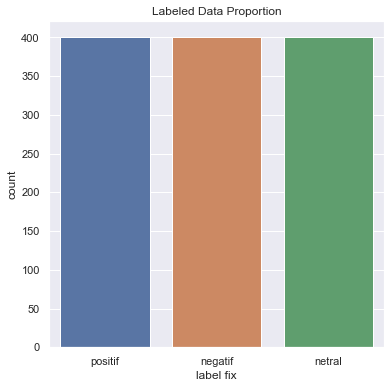

In [297]:
# quick exploration

fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, x='label fix')
ax.set_xticklabels(['positif', 'negatif', 'netral'])
plt.title('Labeled Data Proportion')
plt.show()

In [298]:
def tweet_cleaner(tweet):
  clean_tokens = np.array([])
  lower = tweet.lower()
  no_number = re.sub(r'\d+', '', lower)
  no_url = re.sub(r"http\S+", "", no_number)
  no_dash = no_url.replace("-", " ")
  no_punctuation = no_dash.translate(str.maketrans('', '', string.punctuation))
  no_white_space = re.sub(' +', ' ', no_punctuation)
  tokens = word_tokenize(no_white_space)

  for token in tokens:
    if token in dictionary or token in stop_words:    
      clean_tokens = np.append(clean_tokens, token)
    else:    
      stem_token = stemmer.stem(token)
      clean_tokens = np.append(clean_tokens, stem_token)

  # remove stopwords
  no_stopwords = [i for i in clean_tokens if not i in stop_words and i in dictionary]
  
  stem = stemmer.stem(' '.join(no_stopwords))
  result = re.sub(r'\d+', '', ''.join(stem))
  result = re.sub(' +', ' ', result)
  return result

df.loc[:, 'stem_text'] = df.text.map(tweet_cleaner)
df.head()

,date,lokasi,status,text,time,tweet_id,username,provinsi,label_1,label_2,label_3,label_4,label fix,stem_text
0,2019-01-30,Bekasi - Semarang,200,Mau saran ajasih Pak/Bu kalau mau memakai sis...,21:59,1090625550400409601,@trianani,JAWA BARAT,1,1,1,1,1,saran pakai sistem zonasi jangka perata fasili...
1,2019-01-28,Tangerang Banten,200,setuju saya dukung zonasi. beneran ya pemerin...,17:52,1089838512336224256,@widartoadi,BANTEN,1,1,1,1,1,tuju dukung zonasi perintah poin sekolah kuali...
2,2019-01-28,Jakarta Pusat DKI Jakarta,200,#SahabatItjen Sistem zonasi ini bertujuan untu...,16:51,1089823287624884226,@Itjen_Kemdikbud,DKI JAKARTA,1,1,1,1,1,sistem zonasi tuju perata didik masyarakat sis...
3,2019-01-28,Jakarta Pusat DKI Jakarta,200,#SahabatItjen Sistem zonasi pendidikan dihara...,16:45,1089821719680831488,@Itjen_Kemdikbud,DKI JAKARTA,1,1,1,1,1,sistem zonasi didik harap hilang label sekolah...
4,2019-01-15,yogyakarta indonesia,200,Tambahan pendidikan moral perlu ditingkatkan d...,10:08,1085010825746632705,@djeto_catur,DI YOGYAKARTA,1,3,1,1,1,didik moral tingkat atur seleksi masuk sekolah...


### Split Dataset

In [313]:
# shuffle dataset
df = df.sample(frac=1, random_state=42)

X = df['stem_text']
y = df['label fix']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [324]:
X_train_raw, X_test_raw = train_test_split(X, test_size=0.2, random_state=42)
X_test_raw.head()

161    laku barat zonasi murni jarak zonasi kombinasi...
217    sayang sistem dasar alumni sekolah sih tau gua...
253    giat ajar les pagi siang sore nilai masuk seko...
327    tuju zonasi apik seng anak seng sekolah wing n...
158           kualitas sekolah turun terap sistem zonasi
Name: stem_text, dtype: object

### TF-IDF

In [314]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(0,1))
X_train = tfidf.fit_transform(X_train).toarray()   # ini yang dipakai buat klasifikasi
X_test = tfidf.transform(X_test).toarray()

# Modelling

## Naive Bayes

In [315]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
print('cv train score: {}'.format(np.mean(cross_val_score(nb, X_train, y_train, cv=10))))

y_pred = nb.predict(X_test)
print('test score: {}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

cv train score: 0.6133376288659794
test score: 0.6307053941908713
              precision    recall  f1-score   support

           1       0.64      0.66      0.65        79
           2       0.67      0.56      0.61        91
           3       0.58      0.69      0.63        71

    accuracy                           0.63       241
   macro avg       0.63      0.64      0.63       241
weighted avg       0.64      0.63      0.63       241



## KNN

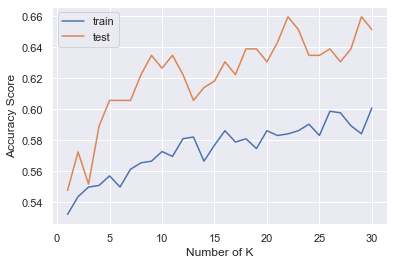

best train accuracy: 0.6009235395189003, best K: 30
best test accuracy: 0.6597510373443983, best K: 22


In [339]:
n_neighbors = range(1, int(math.floor(math.sqrt(len(X_train)))))

knn_train_scores = []
knn_test_scores = []

for k in n_neighbors:
    knn = KNeighborsClassifier(metric='cosine', n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_train_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=10)))
    y_pred = knn.predict(X_test)
    knn_test_scores.append(accuracy_score(y_test, y_pred))

train_plot, = plt.plot(n_neighbors, knn_train_scores, label='train')
test_plot, = plt.plot(n_neighbors, knn_test_scores, label='test')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Number of K')
plt.ylabel('Accuracy Score')
plt.show()

print('best train accuracy: {}, best K: {}'.format(np.max(knn_train_scores), n_neighbors[knn_train_scores.index(np.max(knn_train_scores))]))
print('best test accuracy: {}, best K: {}'.format(np.max(knn_test_scores), n_neighbors[knn_test_scores.index(np.max(knn_test_scores))]))

## Random Forest

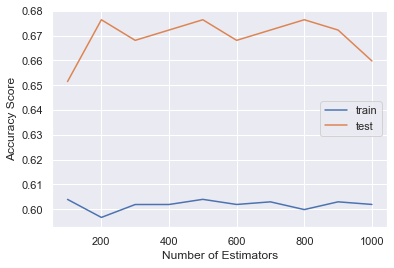

best train accuracy: 0.6039841065292096 -> n_estimator: 500
best test accuracy: 0.6763485477178424 -> n_estimator: 200


In [317]:
n_estimators = list(range(100, 1100, 100))

rfc_train_scores = []
rfc_test_scores = []

for n in n_estimators:
    rfc = RandomForestClassifier(n_estimators=n, random_state=42)
    rfc.fit(X_train, y_train)
    rfc_train_scores.append(np.mean(cross_val_score(rfc, X_train, y_train, cv=10)))
    y_pred = rfc.predict(X_test)
    rfc_test_scores.append(accuracy_score(y_test, y_pred))

train_plot, = plt.plot(n_estimators, rfc_train_scores, label='train')
test_plot, = plt.plot(n_estimators, rfc_test_scores, label='test')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.show()

print('best train accuracy: {} -> n_estimator: {}'.format(np.max(rfc_train_scores), n_estimators[rfc_train_scores.index(np.max(rfc_train_scores))]))
print('best test accuracy: {} -> n_estimator: {}'.format(np.max(rfc_test_scores), n_estimators[rfc_test_scores.index(np.max(rfc_test_scores))]))

## SVM

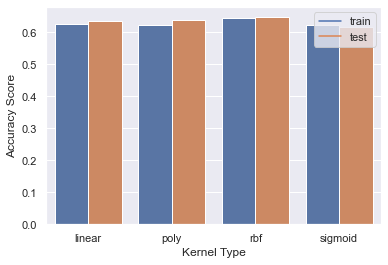

In [318]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

svm_train_scores = []
svm_test_scores = []

for k in kernel:
    svc = SVC(kernel=k, random_state=42)
    svc.fit(X_train, y_train)
    svm_train_scores.append(np.mean(cross_val_score(svc, X_train, y_train, cv=10)))
    y_pred = svc.predict(X_test)
    svm_test_scores.append(accuracy_score(y_test, y_pred))

svm_scores = pd.DataFrame({
    'score': svm_train_scores+svm_test_scores, 
    'type': ['train' for i in svm_train_scores] + ['test' for i in svm_test_scores],
    'kernel': kernel+kernel
})
sns.barplot(data=svm_scores, x='kernel', y='score', hue='type')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Kernel Type')
plt.ylabel('Accuracy Score')
plt.show()

print('best train accuracy: {} -> kernel: {}'.format(np.max(svm_train_scores), kernel[svm_train_scores.index(np.max(svm_train_scores))]))
print('best test accuracy: {} -> kernel: {}'.format(np.max(svm_test_scores), kernel[svm_test_scores.index(np.max(svm_test_scores))]))

In [340]:
print('best train accuracy: {} -> kernel: {}'.format(np.max(svm_train_scores), kernel[svm_train_scores.index(np.max(svm_train_scores))]))
print('best test accuracy: {} -> kernel: {}'.format(np.max(svm_test_scores), kernel[svm_test_scores.index(np.max(svm_test_scores))]))

best train accuracy: 0.6445446735395188 -> kernel: rbf
best test accuracy: 0.6473029045643154 -> kernel: rbf


Based on our findings on several models, we got Random Forest perform better among the other with accuracy score 0.67. So for the production, we will create a Random Forest model.

## Final Model

In [319]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.65      0.68        81
           2       0.63      0.67      0.65        76
           3       0.69      0.70      0.70        84

    accuracy                           0.68       241
   macro avg       0.68      0.68      0.68       241
weighted avg       0.68      0.68      0.68       241



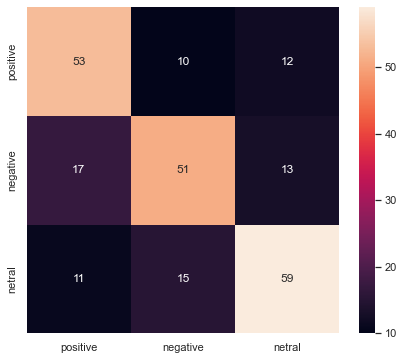

In [320]:
cm = confusion_matrix(y_pred, y_test)
labels = ['positive', 'negative', 'netral']
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

In [321]:
pickle.dump(model, open('./model/model.pkl', 'wb'))
pickle.dump(tfidf, open('./model/vectorizer.pkl', 'wb'))

print('model saved.')
print('vectorizer saved.')

model saved.
vectorizer saved.
